# Digit Recognizer - Feed Foward Net in Theano

**Kyu Cho**  
**11/1/2016**

# Data
- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. 
- Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.  
  
- The training data set, (train.csv), has 785 columns. 
- The first column, called "label", is the digit that was drawn by the user. 
- The rest of the columns contain the pixel-values of the associated image.  
  
- Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. 
- To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. 
- Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
    + For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

000 001 002 003 ... 026 027  
028 029 030 031 ... 054 055  
056 057 058 059 ... 082 083  
 |   |   |   |  ...  |   |  
728 729 730 731 ... 754 755  
756 757 758 759 ... 782 783   

# Techniques Used

1. Feed Forward
2. TODO: Drop out
3. TODO Nesterov and RMSprop
4. Ragulization
5. Learning Rate
6. Batch Gradient
7. Normalization or PCA

# Table of Contents
1. Load Data
2. Split Data
3. Function initialization
4. Build Model

## Load Data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import theano.tensor as T

def get_normalized_data():
    print "Reading in and transforming data..."
    df = pd.read_csv('../large_files/train.csv')
    
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    
    Y = data[:, 0]
    X = data[:, 1:]
    
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    
    return X, Y

In [2]:
X, Y = get_normalized_data()
X.shape, Y.shape

Reading in and transforming data...


((42000, 784), (42000,))

## Split train and test set

In [3]:
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]

In [4]:
Xtrain.shape, Ytrain.shape

((41000, 784), (41000,))

In [5]:
# create indicator matrix, represent digit in location for each row
# ex) digit 9 -> indicate 1 in 9th column
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10)) # digit has 0 to 9 (10 number)
    for i in xrange(N):
        ind[i, y[i]] = 1
    return ind

In [6]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Initialization

### Derivative function

In [7]:
# Derivative functions are replaced by theano update function

### Feed Foward and Cost function

In [8]:
# Feed Forward and Cost functions are replaced by theano function

def relu(a):
    return a * (a > 0)

def error_rate(p, t):
    return np.mean(p != t)

## Build Model

In [9]:
def ANN(n_hdim):
    
    # initialize hyper-parameters
    max_iter = 5  # 5 iteration for sigmoid
    print_period = 100 # print every 10 iterations
    lr = 0.00004 # learning rate
    reg = 0.01 # regulization rate
    batch_sz = 1000 # batch size
    N, D = Xtrain.shape # 41000, 784
    n_batches = N / batch_sz  # number of batches
    M = n_hdim # hidden layer dmention
    K = 10 # number of output '0' to '9' so 10 numbers
    
    # initialize weight and bias
    W1_init = np.random.randn(D, M) / np.sqrt(D)  # 784x300
    b1_init = np.zeros(M)
    W2_init = np.random.randn(M, K) / np.sqrt(M)  # 300x10
    b2_init = np.zeros(K)
      
        
    ################################ Theano Area Start ################################
    
    # create theano var., usually the data will be the input
    thX = T.matrix('X')		# static(not a reference variable)
    thT = T.matrix('T')		# static(not a reference variable)
    
    # convert python var. to theano var
    W1 = theano.shared(W1_init, 'W1')	# dynamic(a reference variable)
    b1 = theano.shared(b1_init, 'b1')	# dynamic(a reference variable)
    W2 = theano.shared(W2_init, 'W2')	# dynamic(a reference variable)
    b2 = theano.shared(b2_init, 'b2')	# dynamic(a reference variable)

    # define forward function
    thZ = relu(thX.dot(W1) + b1)
    thY = T.nnet.softmax(thZ.dot(W2) + b2)
    
    # define the cost function
    cost = -(thT * T.log(thY)).sum()
    
    # define prediction function
    prediction = T.argmax(thY, axis=1)

    # define another prediction function to run though whole dataset
    get_prediction = theano.function(
        inputs=[thX, thT],
        outputs=[cost, prediction],
    )

    # define update expression
    update_W1 = W1 - lr*(T.grad(cost, W1) + reg*W1)
    update_b1 = b1 - lr*(T.grad(cost, b1) + reg*b1)
    update_W2 = W2 - lr*(T.grad(cost, W2) + reg*W2)
    update_b2 = b2 - lr*(T.grad(cost, b2) + reg*b2)

    # define train function
    # updates takes list of tubles as (shared variable, expression)
    train = theano.function(
        inputs=[thX, thT],
        updates=[(W1, update_W1), 
                 (b1, update_b1), 
                 (W2, update_W2), 
                 (b2, update_b2)],
    )
    ################################ Theano Area End  ################################

    LL = []
    for i in xrange(max_iter):
        for j in xrange(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            train(Xbatch, Ybatch) # update the values only

            if j % print_period == 0:
                cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
                err = error_rate(prediction_val, Ytest)

                print "Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err)
                LL.append(cost_val)

    plt.plot(LL)
    plt.show()

Cost / err at iteration i=0, j=0: 2451.687 / 0.894
Cost / err at iteration i=1, j=0: 1186.349 / 0.312
Cost / err at iteration i=2, j=0: 783.695 / 0.207
Cost / err at iteration i=3, j=0: 616.792 / 0.171
Cost / err at iteration i=4, j=0: 530.932 / 0.151


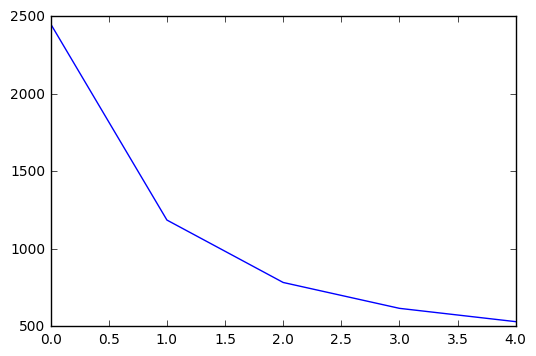

Cost / err at iteration i=0, j=0: 2323.525 / 0.856
Cost / err at iteration i=1, j=0: 677.954 / 0.176
Cost / err at iteration i=2, j=0: 492.810 / 0.138
Cost / err at iteration i=3, j=0: 416.015 / 0.116
Cost / err at iteration i=4, j=0: 371.082 / 0.107


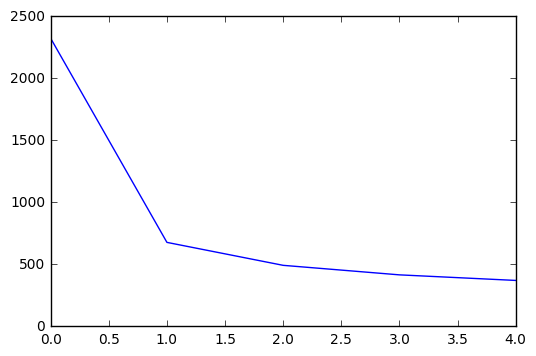

Cost / err at iteration i=0, j=0: 2194.970 / 0.766
Cost / err at iteration i=1, j=0: 603.810 / 0.160
Cost / err at iteration i=2, j=0: 454.260 / 0.127
Cost / err at iteration i=3, j=0: 390.279 / 0.115
Cost / err at iteration i=4, j=0: 351.990 / 0.097


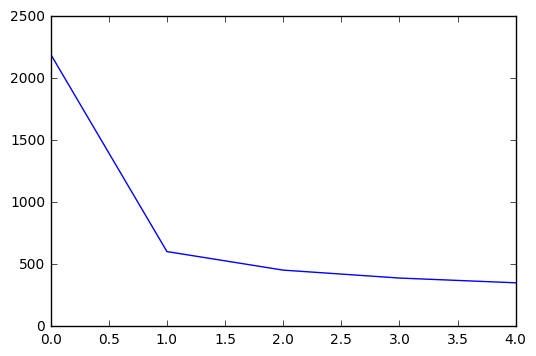

Cost / err at iteration i=0, j=0: 2108.171 / 0.718
Cost / err at iteration i=1, j=0: 565.997 / 0.153
Cost / err at iteration i=2, j=0: 432.631 / 0.127
Cost / err at iteration i=3, j=0: 374.025 / 0.110
Cost / err at iteration i=4, j=0: 338.631 / 0.099


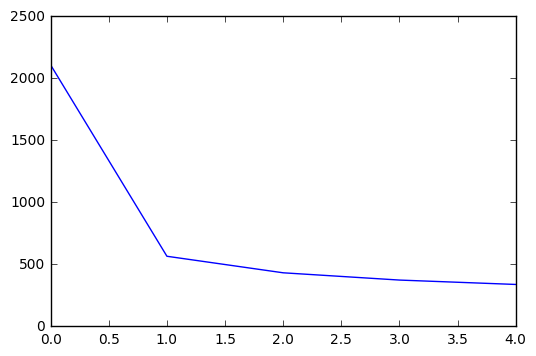

In [10]:
if __name__ == '__main__':
    ANN(n_hdim = 10)
    ANN(n_hdim = 500)
    ANN(n_hdim = 1000)
    ANN(n_hdim = 1500)

- Interesting result
    + Nesterov drops the error rate faster but rms eventually got better.